In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sempler
from sempler import functions, noise, utils
from sklearn.gaussian_process import GaussianProcessRegressor as GP
import sklearn.gaussian_process.kernels as kernels

### Generate data from an ANM

/home/juan/anaconda3/lib/python3.7/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))
/home/juan/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/juan/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


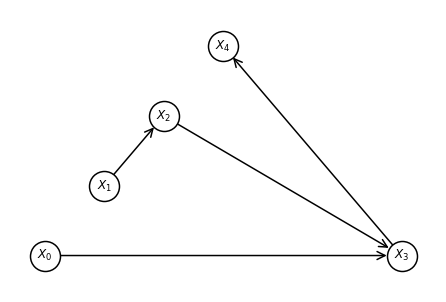

In [2]:
A = np.array([[0, 0, 0, 1, 0],
              [0, 0, 1, 0, 0],
              [0, 0, 0, 1, 0],
              [0, 0, 0, 0, 1],
              [0, 0, 0, 0, 0]
             ])
utils.plot_graph(A)

In [3]:
noise_distributions = [noise.normal(), noise.normal(), noise.normal(0,0.01), noise.normal(0,0.01), noise.normal(0,0.01)]
functions = [None, None, lambda x: np.sin(2*x), lambda x: 1*np.exp(x[:,0]) + 2*x[:,1], lambda x: 2*x]
anm = sempler.ANM(A, functions, noise_distributions)

[-0.07138964 -0.13458006 -0.01261766  2.03913365  4.0502886 ] [ 1.41688643  0.79439234  0.39755131 15.32969031 61.36158767]


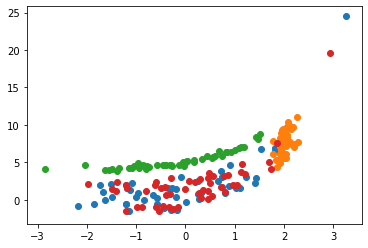

In [4]:
n = 50
X = anm.sample(n, debug=False)
X1 = anm.sample(n, do_interventions = {0: noise.normal(2, 0.01)})
X2 = anm.sample(n, do_interventions = {2: noise.normal(2, 0.01)})
X3 = anm.sample(n, do_interventions = {4: noise.normal(0, 0.01)})
plt.scatter(X[:,0], X[:,3])
plt.scatter(X1[:,0], X1[:,3])
plt.scatter(X2[:,0], X2[:,3])
plt.scatter(X3[:,0], X3[:,3])
print(X.mean(axis=0), X.var(axis=0))

### GP Regression

In [5]:
def regress(data, S, y, plot=False):
    kernel = kernels.DotProduct()
    gpr = GP(alpha=1).fit(data[:,S], data[:,y])
    base = []
    for i in range(len(S)):
        base.append(np.linspace(data[:,S[i]].min(), data[:,S[i]].max(), 100))
    base = np.vstack(base).T
    if plot:
        (mean, std) = gpr.predict(base, return_std=True)
        top, bottom = mean + std, mean - std        
        plt.plot(base[:,0], mean, color='red')
        plt.fill_between(base[:,0], top, bottom, color='gray', alpha=0.4)
    residuals = data[:,y] - gpr.predict(data[:,S])
    return gpr, residuals

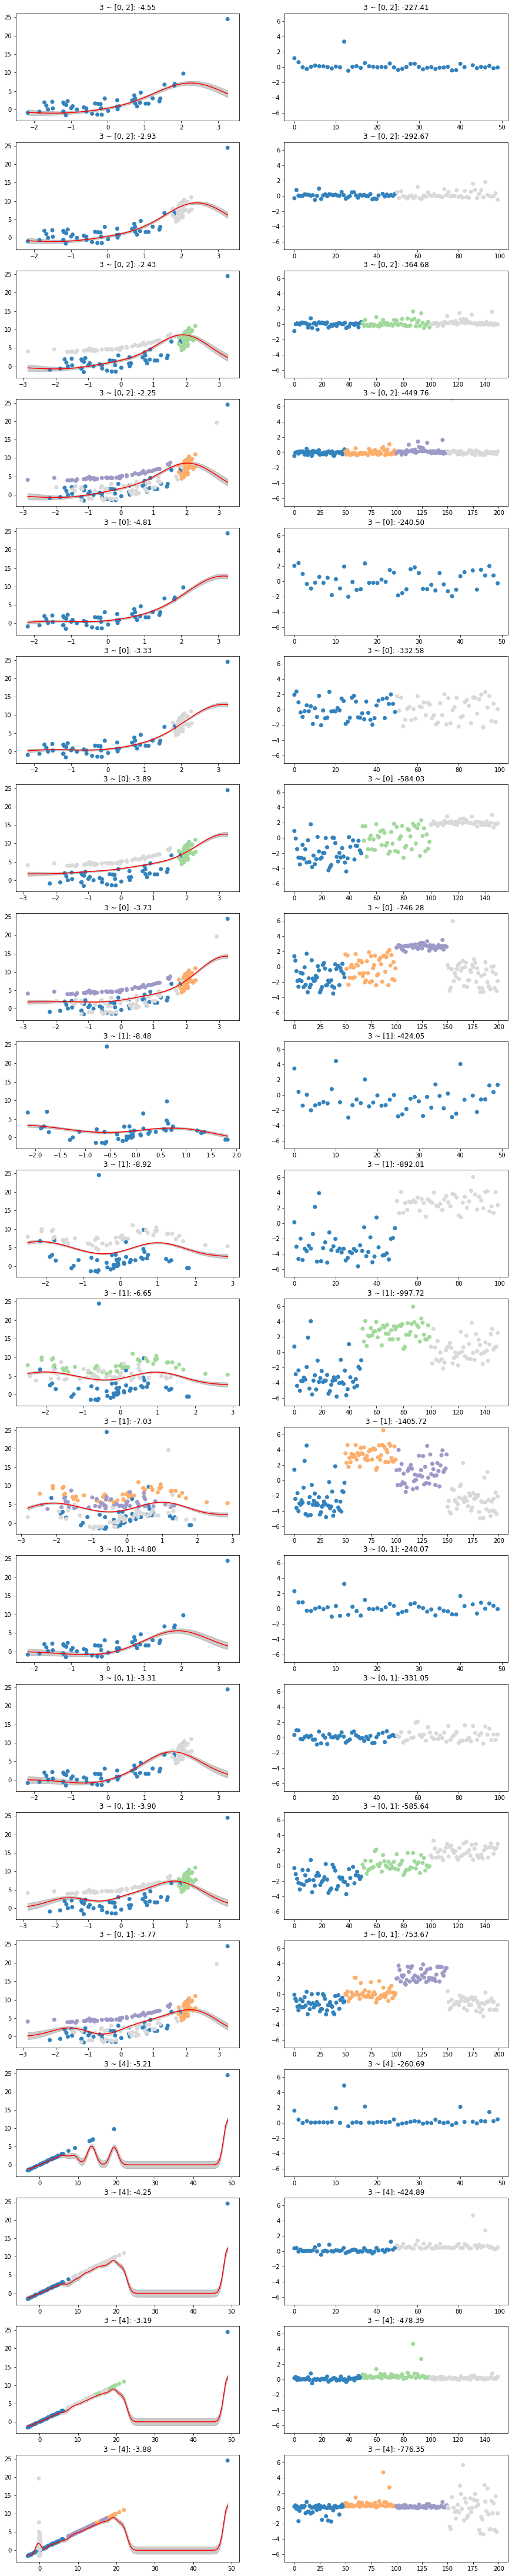

In [6]:
experiments = [(3, [0,2], [X]),
               (3, [0,2], [X, X1]),
               (3, [0,2], [X, X1, X2]),
               (3, [0,2], [X, X1, X2, X3]),
               (3, [0], [X]),
               (3, [0], [X, X1]),
               (3, [0], [X, X1, X2]),
               (3, [0], [X, X1, X2, X3]),
               (3, [1], [X]),
               (3, [1], [X, X1]),
               (3, [1], [X, X1, X2]),
               (3, [1], [X, X1, X2, X3]),
               (3, [0,1], [X]),
               (3, [0,1], [X, X1]),
               (3, [0,1], [X, X1, X2]),
               (3, [0,1], [X, X1, X2, X3]),
               (3, [4], [X]),
               (3, [4], [X, X1]),
               (3, [4], [X, X1, X2]),
               (3, [4], [X, X1, X2, X3]),
              ]

plt.figure(figsize=(15,len(experiments)*8))
ylim = [-7,7]
cmap = 'tab20c'
rows = len(experiments) * 2

for i, (y, S, data) in enumerate(experiments):
    plt.subplot(rows,2,2*i+1)
    pooled = np.vstack(data)
    gpr, residuals = regress(pooled, S, y, plot=True)
    plt.title("%d ~ %s: %0.2f" % (y,S,gpr.log_marginal_likelihood()/len(pooled)))
    last = 0
    idx = []
    for j,Xe in enumerate(data):
        idx = np.hstack([idx, np.ones(len(Xe))*j])
    plt.scatter(pooled[:, S[0]], pooled[:,y], c=idx, cmap=cmap)
    plt.subplot(rows, 2, 2*i+2)
    plt.ylim(ylim)
    plt.scatter(np.arange(len(residuals)), residuals, c=idx, cmap=cmap)
    plt.title("%d ~ %s: %0.2f" % (y,S,gpr.log_marginal_likelihood()))
